# Mount to drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = '/content/gdrive/My Drive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data

In [ ]:
import pandas as pd
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv(gdrive_path+"product_images.csv")
df = df.sample(frac=1).reset_index(drop=True)

In [ ]:
# split data into test & train
data = df.to_numpy()

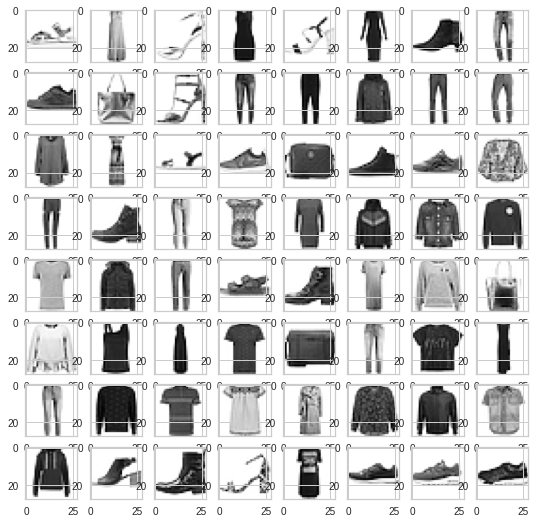

In [ ]:
plt.figure(figsize = (10,9))

bottom = 0.2

for i in range(64):
  plt.subplots_adjust(bottom)
  plt.subplot(8,8,i+1)
  plt.imshow(np.reshape(data[:64], (64,28,28))[i])

# Utility Functions

In [ ]:
import random

In [ ]:
def show_group(group, g):
  plt.figure(figsize=(10,10))
  for i, v in enumerate(random.sample(group[g], 64)):
    plt.subplots_adjust(0.2)
    plt.subplot(8,8,i+1)
    plt.imshow(np.reshape(data, (10000, 28,28))[v])

In [ ]:
def group_by_clusters(labels):
  map = {}

  for i in range(len(set(labels))):
    map[i]=[ k for k,v in enumerate(kmeans.labels_) if v == i]
  
  return map

In [ ]:
def display_img(pixels):
  plt.figure(figsize=(1,1))
  plt.imshow(np.reshape(pixels, (28,28)))

In [ ]:
def normalise(imgs):
  return np.array([(img-min(img))/(max(img)-min(img)) for img in imgs])

In [ ]:
def normalise_img(img):
  return(img-min(img))/(max(img)-min(img)) 


# Preprocessing

In [ ]:
from skimage import exposure
from sklearn import preprocessing

In [ ]:
# Conversion to float
X = data.astype('float64') 

# Normalise
X = X/255.0

# Equaliee exposure
X = np.array([exposure.equalize_hist(each) for each in X])

# # Normalise
X = np.array([normalise_img(each) for each in X])

# Reshaping input data
X = X.reshape(len(data),-1)


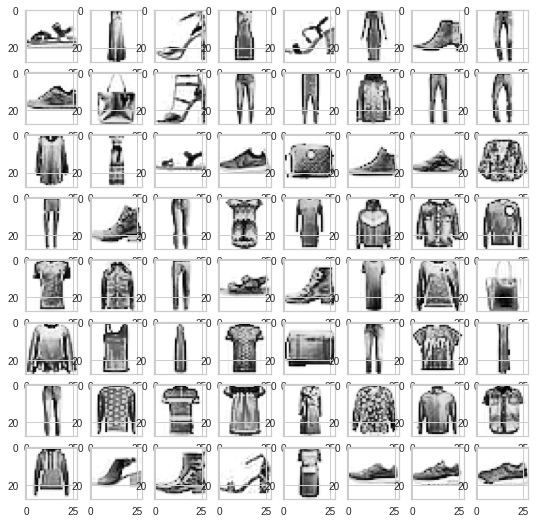

In [ ]:
# display preprocessed data
plt.figure(figsize = (10,9))

bottom = 0.2

for i in range(64):
  plt.subplots_adjust(bottom)
  plt.subplot(8,8,i+1)
  plt.imshow(np.reshape(X[:64], (64,28,28))[i])

## PCA



In [ ]:
from sklearn.decomposition import PCA

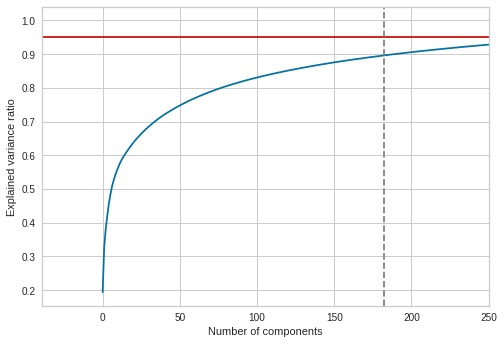

In [ ]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.xlim(right=250)
plt.ylabel('Explained variance ratio')
plt.axhline(0.95, color = 'r', linestyle = '-')
plt.axvline(x=182, color='gray', linestyle='--')
plt.show()

In [ ]:
pca = PCA(n_components = 182)
pca.fit(X)
X_pca = pca.transform(X)

## IncrementalPCA

In [ ]:
from sklearn.decomposition import IncrementalPCA

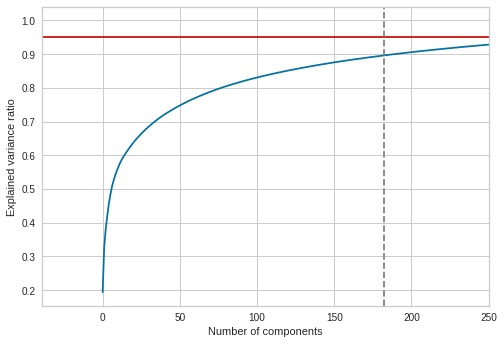

In [ ]:
pca = IncrementalPCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.xlim(right=250)
plt.ylabel('Explained variance ratio')
plt.axhline(0.95, color = 'r', linestyle = '-')
plt.axvline(x=182, color='gray', linestyle='--')
plt.show()

In [ ]:
pca = IncrementalPCA(n_components = 182)
pca.fit(X)
X_ipca = pca.transform(X)

## NN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_size = 28*28

# Define an autoencoder with three layers
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(input_size,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(input_size, activation='linear'))

# Compile the model with a loss function and optimizer
model.compile(loss='mse', optimizer='adam')

# Train the model on the input data
model.fit(X, X, batch_size=32, epochs=10)

# Extract features from the bottleneck layer of the trained autoencoder
feature_extractor = Sequential(model.layers[:3])

# Use the feature extractor to transform the input data
X_nn = feature_extractor.predict(X)

Epoch 1/10
313/313 [==============================] - 4s 9ms/step - loss: 0.0449
Epoch 2/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0308
Epoch 3/10
313/313 [==============================] - 3s 11ms/step - loss: 0.0272
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0253
Epoch 5/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0241
Epoch 6/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0232
Epoch 7/10
313/313 [==============================] - 3s 9ms/step - loss: 0.0225
Epoch 8/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0219
Epoch 9/10
313/313 [==============================] - 4s 11ms/step - loss: 0.0214
Epoch 10/10
313/313 [==============================] - 1s 2ms/step


## Manifold Learning

t-SNE

In [ ]:
from sklearn import manifold
import numpy as np
# Perform feature extraction using t-SNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Isomap

In [ ]:
# Perform feature extraction using Isomap
isomap = manifold.Isomap(n_neighbors=5, n_components=2)
X_isomap = isomap.fit_transform(X)

In [ ]:
# Print the shape of the new feature spaces
print("t-SNE feature space shape:", X_tsne.shape)
print("Isomap feature space shape:", X_isomap.shape)

t-SNE feature space shape: (10000, 2)
Isomap feature space shape: (10000, 2)


# Choosing feature extraction method

In [ ]:
total_clusters = 9

In [ ]:
scores = {}

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
def get_silelbow(X, total_clusters):
  kmeans = MiniBatchKMeans(n_clusters = total_clusters)
  kmeans.fit(X)

  # Import the KElbowVisualizer method 
  visualiser = KElbowVisualizer(kmeans, k=(2,15), metric='silhouette', timings=False)

  # Fit the data and visualize
  visualiser.fit(X)    
  visualiser.poof()

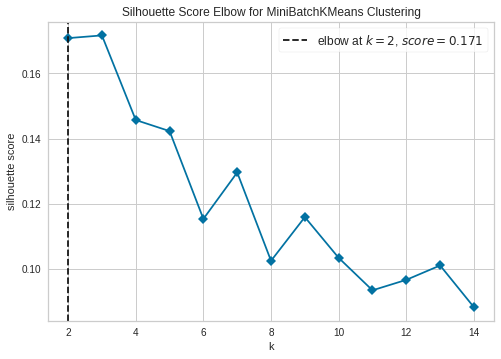

In [ ]:
get_silelbow(X, total_clusters)

In [ ]:
# choose 
n = 9
kmeans = MiniBatchKMeans(n_clusters = n)
kmeans.fit(X)
scores["all_features"] = silhouette_score(X, kmeans.labels_)

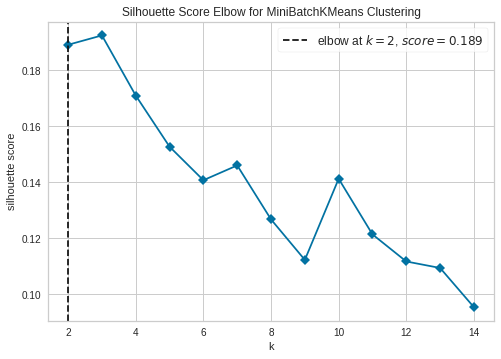

In [ ]:
get_silelbow(X_pca, total_clusters)

In [ ]:
# choose 
n = 7
kmeans = MiniBatchKMeans(n_clusters = n)
kmeans.fit(X_pca)
scores["pca"] = silhouette_score(X_pca, kmeans.labels_)

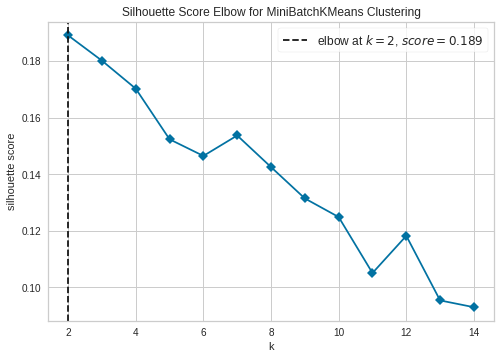

In [ ]:
get_silelbow(X_ipca, total_clusters)

In [ ]:
# choose 
n = 10
kmeans = MiniBatchKMeans(n_clusters = n)
kmeans.fit(X_ipca)
scores["ipca"] = silhouette_score(X_ipca, kmeans.labels_)

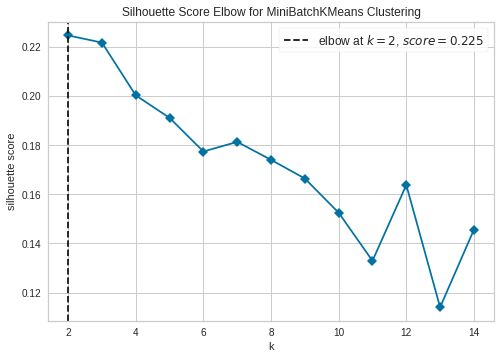

In [ ]:
get_silelbow(X_nn, total_clusters)

In [ ]:
# choose 
n = 8
kmeans = MiniBatchKMeans(n_clusters = n)
kmeans.fit(X_nn)
scores["nn"] = silhouette_score(X_nn, kmeans.labels_)

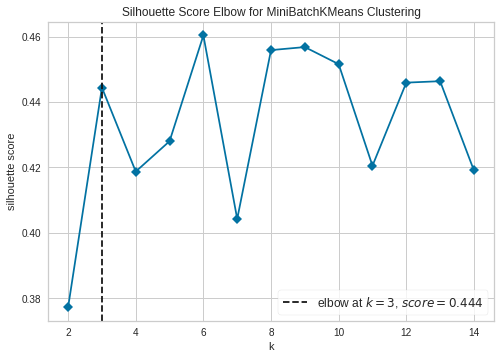

In [ ]:
get_silelbow(X_tsne, total_clusters)

In [ ]:
# choose 
n = 8
kmeans = MiniBatchKMeans(n_clusters = n)
kmeans.fit(X_tsne)
scores["tsne"] = silhouette_score(X_tsne, kmeans.labels_)

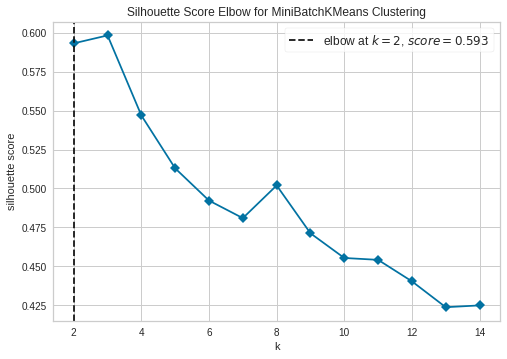

In [ ]:
get_silelbow(X_isomap, total_clusters)

In [ ]:
# choose 
n = 7
kmeans = MiniBatchKMeans(n_clusters = n)
kmeans.fit(X_isomap)
scores["isomap"] = silhouette_score(X_isomap, kmeans.labels_)

In [ ]:
scores

{'all_features': 0.10540809462735055,
 'pca': 0.1351760427874139,
 'ipca': 0.11443077928129239,
 'nn': 0.16832271,
 'tsne': 0.44270796,
 'isomap': 0.4779689808705446}

# Optimal k

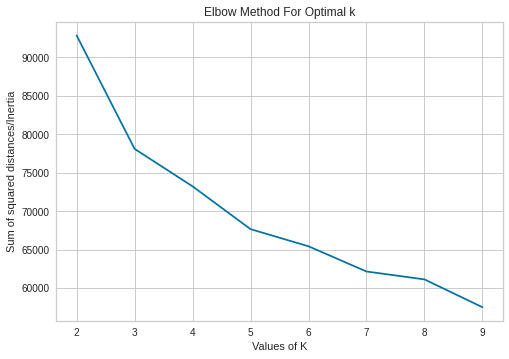

In [ ]:
Sum_of_squared_distances = []
K = range(2,10)
for num_clusters in K :
 kmeans = MiniBatchKMeans(n_clusters=num_clusters)
 kmeans.fit(X_nn)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

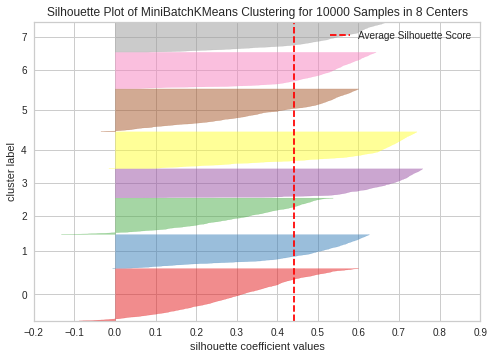

In [ ]:
SilhouetteVisualizer(MiniBatchKMeans(n_clusters=8)).fit(X_tsne).show()

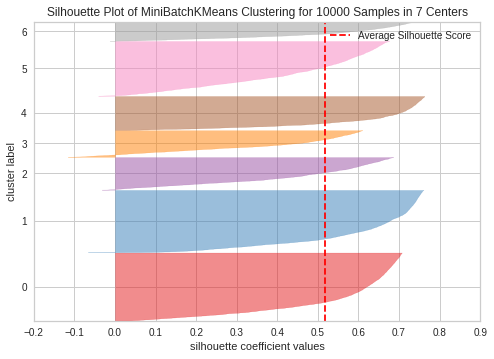

In [ ]:
SilhouetteVisualizer(MiniBatchKMeans(n_clusters=7)).fit(X_isomap).show()

# Choose Preprocessing with t-SNE and n=8 to build final model

In [ ]:
kmeans = MiniBatchKMeans(n_clusters = 8)
kmeans.fit(X_tsne)

MiniBatchKMeans()

In [ ]:
group = group_by_clusters(kmeans.labels_)

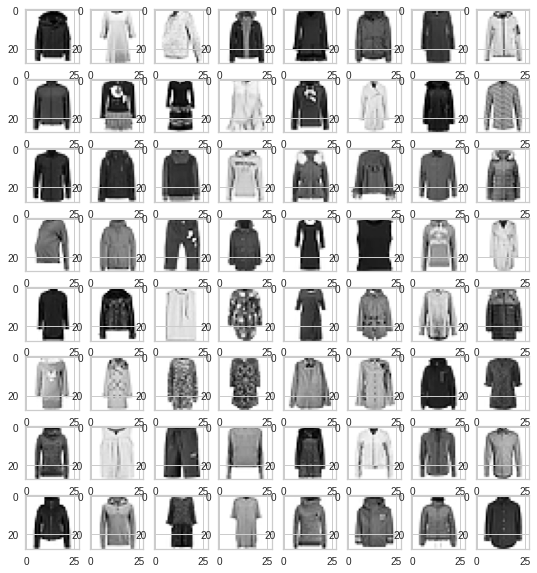

In [ ]:
show_group(group, 0) # dresses

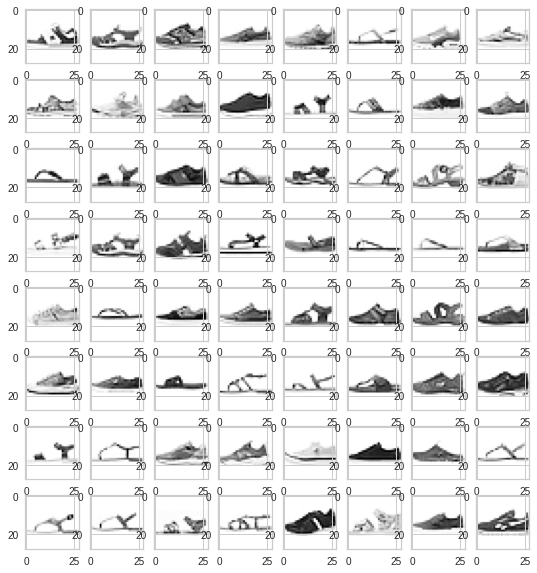

In [ ]:
show_group(group, 1) # boots & heels

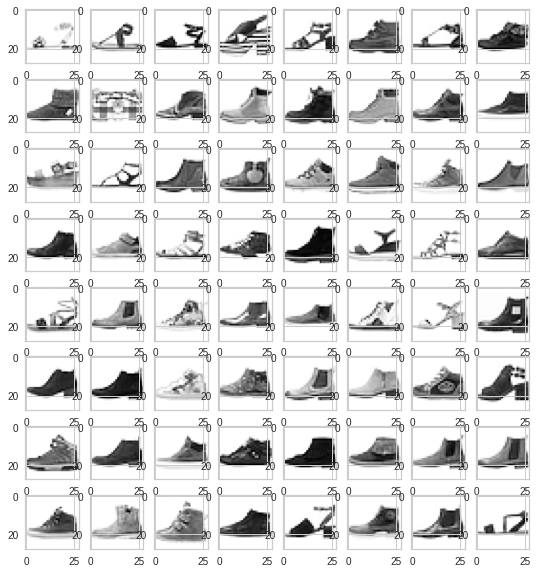

In [ ]:
show_group(group, 2) # boots & heels

# Final Functions

In [ ]:
from numpy import save
from numpy import load

save(gdrive_path+'X_tsne.npy', X_tsne)

In [ ]:
X_tsne = load(gdrive_path+'X_tsne.npy')

In [ ]:
def get_model():
  X_tsne = load(gdrive_path+'X_tsne.npy')

  kmeans = MiniBatchKMeans(n_clusters = 8)
  kmeans.fit(X_tsne)
  return kmeans

In [ ]:
model=get_model()

In [ ]:
save(gdrive_path+'labels.npy', model.labels_)

In [ ]:
save(gdrive_path+'centres.npy', model.cluster_centers_)

In [ ]:
labels = model.labels_

In [ ]:
labels

array([7, 5, 4, ..., 1, 4, 5], dtype=int32)